In [2]:
import sys
sys.path.append('/home/achint/Generative_Modelling/Ziyi_new/POISEVAEv1-master')
import os, copy, time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal, Laplace
from tqdm import tqdm
import matplotlib.pyplot as plt
import poisevae
from poisevae.utils import CategoricalImage as Categorical
from poisevae.datasets import MNIST_MNIST
from poisevae.networks.MNISTMNISTNetworks_X import EncMNIST1, DecMNIST1, EncMNIST2, DecMNIST2
from poisevae.networks.MNISTMNISTNetworks_pixelcnn import pixelcnn_decoder
# from poisevae.networks.conv_layers import MaskedConv2d, CroppedConv2d
from poisevae.networks.model import PixelCNN

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
MNIST_PATH = "/home/achint/datasets/MNIST/%s.pt"
SVHN_PATH = "/home/achint/datasets/SVHN/%s_32x32.mat"

joint_dataset_train = MNIST_MNIST.MNIST_MNIST(mnist_pt_path_1=MNIST_PATH % 'training', mnist_pt_path_2=MNIST_PATH % 'training')
joint_dataset_test  = MNIST_MNIST.MNIST_MNIST(mnist_pt_path_1=MNIST_PATH % 'test', mnist_pt_path_2=MNIST_PATH % 'test')

In [4]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(joint_dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(joint_dataset_test, batch_size=batch_size, shuffle=True, drop_last=True)
len(train_loader), len(test_loader)

(1875, 312)

In [5]:
# def loss_function(x_rec, x):
#     x_rec = x_rec.flatten(-3,-1)#.flatten(0, 1)
#     color_level = 256
#     x = (x * (color_level - 1)).floor()#.long()
#     x_ = torch.zeros_like(x_rec)#.long()
#     for i in range(x_rec.shape[0]):
#         x_[i, :] = x[i].unsqueeze(0)
    
#     print(x_rec.shape, x_.shape)
#     x_rec = x_rec.flatten(0, 1)
#     x_ = x_.flatten(0, 1)
    
#     ce_loss = nn.CrossEntropyLoss(reduction='none')
#     print(x_rec.shape, x_.shape)
#     MSE = ce_loss(x_rec,x_).sum(dim=-1)
#     print(MSE.shape)
#     return MSE

In [8]:
lat1, lat2 = 20, 20
enc_mnist1 = EncMNIST1(lat1, lat2).to(device)
enc_mnist2 = EncMNIST2(lat1, lat2).to(device)

dec_mnist1 = pixelcnn_decoder(PixelCNN(lat1, 1)).to(device)
dec_mnist2 = pixelcnn_decoder(PixelCNN(lat1, 1)).to(device)

# Options: 'autograd' and 'gradient'  or 'std_normal' and 'derivative'
vae = poisevae.POISEVAE_Gibbs('gradient',
                              [enc_mnist1, enc_mnist2], [dec_mnist1, dec_mnist2], likelihoods=[Categorical, Categorical],#likelihoods=[Laplace, Laplace], 
                              latent_dims=[lat1, (lat2)], enc_config='nu', KL_calc='derivative', 
                              batch_size=batch_size, reduction='mean'
                             ).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
writer = None


In [9]:
PATH = '/home/achint/runs'
epoch = 0
epochs = 1 + epoch
# fname = 'out%s.txt' % time.strftime('%m%d%H%M%S')
# G = [vae.get_G().detach().cpu().numpy()]
# detach_G = True

for epoch in tqdm(range(epoch, epochs)):
#     with poisevae._debug.Capturing(fname, disable_print=False) as output:
    poisevae.utils.train(vae, train_loader, optimizer, epoch, 3, 2, writer,dec_kwargs=dict(img=torch.zeros(batch_size * 2, 784), generate_mode=False) )
#     G.append(vae.get_G().detach().cpu().numpy())

#     poisevae.utils.test(vae, test_loader, epoch, 3, 2, writer, img=torch.zeros(batch_size * 2, 784), generate_mode=False)
    if (epoch+1) % 10 == 0 and epoch > 0:
        poisevae.utils.save_checkpoint(vae, optimizer, os.path.join(PATH, 'training_%d.pt' % (epoch+1)), epoch+1)


  0%|                                                     | 0/1 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (896x28 and 784x512)

In [7]:
poisevae.utils.save_checkpoint(vae, optimizer, os.path.join(PATH, 'training_%d.pt' % (epoch+1)), epoch+1)

In [8]:
with torch.no_grad():
    for i, data in enumerate(test_loader):
        results = vae([data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.float32)], n_gibbs_iter=2,dec_kwargs=dict(img=torch.zeros(batch_size * 2, 784), generate_mode=False))
        break

log_var_mnist2 torch.Size([32, 20])


In [9]:
x_rec = results['x_rec']
if isinstance(x_rec[0], torch.distributions.Distribution):
#     x_rec = [x_rec[0].probs, x_rec[1].probs]
#     idx = torch.where(results['weights'] == results['weights'].max(dim=1).values[:, None])
    x_rec = [x_rec[0].loc[idx], x_rec[1].loc[idx]] # (batch, IW samples, ...)

In [10]:
x_rec[0].size()

torch.Size([32, 1, 28, 28])

In [11]:
# fig, ax = plt.subplots(14, 14, figsize=(24, 24), sharex='all', sharey='all')
# for i in range(14):
#     for j in range(14):
#         ax[i, j].plot(x_rec[0][:1, :, 0, i * 2, j * 2].T)
#         ax[i, j].set_title((i * 2, j * 2))
# fig.tight_layout()

In [12]:
# x_rec = [x_rec[0][:, 0]]# - x_rec[0][:, -1]]
# x_rec = [x_rec[0].max(dim=1).indices.squeeze(),x_rec[1].max(dim=1).indices.squeeze()]
x_rec[0].shape

torch.Size([32, 1, 28, 28])

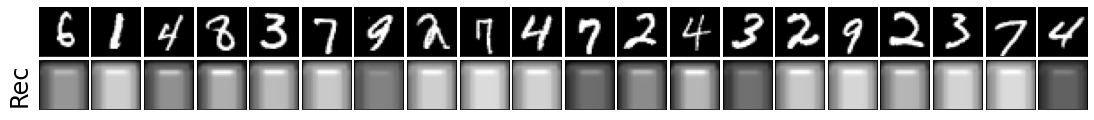

In [13]:
ncols = min(len(x_rec[0]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data[0], x_rec[0])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().reshape(28, 28), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'MNISTRec.pdf', dpi=300)

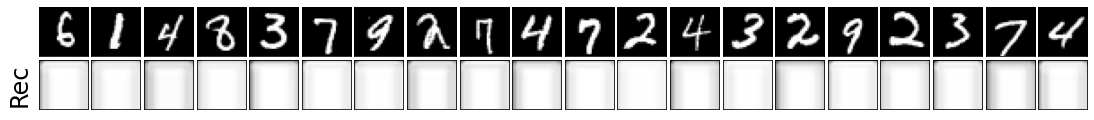

In [14]:
ncols = min(len(x_rec[1]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data[1], x_rec[1])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().reshape(28, 28), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)

In [15]:
x_rec = results['x_rec']
if isinstance(x_rec[0], torch.distributions.Distribution):
    x_rec = [x_rec[0].probs, x_rec[1].probs]

In [16]:
x_rec

[tensor([[[[ 8.9735e-05, -8.5023e-04, -3.7892e-03,  ..., -3.2369e-03,
            -3.2369e-03, -3.2369e-03],
           [-4.2694e-03, -3.9535e-03, -3.8911e-03,  ..., -3.8759e-03,
            -3.7551e-03, -3.6084e-03],
           [-3.9141e-03, -3.6901e-03, -3.3987e-03,  ..., -3.5002e-03,
            -3.6536e-03, -3.5780e-03],
           ...,
           [-3.4560e-03, -3.1513e-03, -2.9514e-03,  ..., -2.7242e-03,
            -3.1079e-03, -3.5064e-03],
           [-3.4560e-03, -3.1513e-03, -2.9514e-03,  ..., -2.7242e-03,
            -3.1079e-03, -3.5064e-03],
           [-3.4560e-03, -3.1513e-03, -2.9514e-03,  ..., -2.7242e-03,
            -3.1079e-03, -3.5064e-03]]],
 
 
         [[[-5.1874e-03, -1.5930e-03, -3.2926e-03,  ..., -3.7898e-03,
            -3.7898e-03, -3.7898e-03],
           [-4.6502e-03, -4.7424e-03, -4.7311e-03,  ..., -4.7904e-03,
            -4.8943e-03, -5.0436e-03],
           [-4.4518e-03, -4.2582e-03, -3.9283e-03,  ..., -4.0572e-03,
            -4.3373e-03, -4.4712e-03

In [17]:
x_rec = results['x_rec']
torch.sum(x_rec[0].probs,dim=-1)

AttributeError: 'Tensor' object has no attribute 'probs'

In [ ]:
x_rec[0].max()

In [ ]:
x_rec1 = x_rec[0].max(dim = -1).indices.squeeze()#[:, -1]

In [ ]:
data[0].min()

In [ ]:
epochs = ([1])
fig, ax = plt.subplots(ncols=len(epochs), nrows=4, figsize=(12, 8), sharex='col')

for j, t in enumerate(epochs):
    vae, _, _ = poisevae.utils.load_checkpoint(vae, load_path=os.path.join(PATH, 'training_%d.pt'%t))
    with torch.no_grad():
        for _, data in enumerate(test_loader):
            results = vae([data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.float32)],img=torch.zeros(batch_size * 2, 784), generate_mode=False)
            break
    mu, var = results['param1'], results['param2']
    for i in (0, 1):
        ax[j, i].plot(mu[i].detach().cpu().numpy().T)
        ax[j, i].set_title('mu%d' % (i+1))
        ax[j, 2+i].plot(var[i].detach().cpu().numpy().T)
        ax[j, 2+i].set_title('var%d' % (i+1))
    ax[j, 0].set_ylabel('epoch = %d' % t)
fig.tight_layout(pad=0)